In [1]:
import numpy as np
import os
import glob
from configobj import ConfigObj
from scipy.io import wavfile
import time

from outliers import smirnov_grubbs as grubbs
from scipy import stats as st
from scipy.signal import medfilt
from itertools import product

from multiprocessing import Pool
from multiprocessing import cpu_count
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from offset import find_offset

In [2]:
def get_ref_chunk(C_ref, offset, query_hps):
    return C_ref[:,offset:offset+len(query_hps)]

In [3]:
def grubbs_outliers(query_deltas, ref_deltas, threshold=0.05):
    '''
    Given the query and reference deltas, return a bool array of outliers marked 
    by 1 given by the Grubbs test.
    
    Args:
        threshold: statistical significance used for Grubbs test
    '''
    diffs = query_deltas - ref_deltas
    outliers = np.zeros(diffs.shape, dtype=np.uint8)
    for bit in range(outliers.shape[0]):
        indices = grubbs.two_sided_test_indices(diffs[bit, :], alpha=threshold)
        outliers[bit, indices] = 1
    return outliers

In [4]:
def majority_vote(outliers, majority=None):
    '''
    Given an outlier array, return the result of voting.
    
    Args:
        majority: the number of votes needed for a column to be considered tampered. 
    '''
    if not majority:
        majority = outliers.shape[0] // 2
    return (outliers.sum(axis=0) >= majority).astype('uint8')

In [5]:
def iqr_outliers(query_deltas, ref_deltas, multiplier=1.5, std_multiplier=0.1):
    '''
    Given query and reference deltas, return a bool array of outliers marked
    by 1 given by the IQR method. 
    
    Args:
        multiplier: the multiplier used for determining outliers from the IQR.
        std_multiplier: lower bound the IQR using the standard deviation of the 
                        reference deltas. Set to 0 to disable. 
    '''
    diffs = query_deltas - ref_deltas
    outliers = np.zeros(diffs.shape, dtype=np.uint8)
    for bit in range(outliers.shape[0]):
        a = diffs[bit]
        IQR = np.percentile(a, 75) - np.percentile(a, 25)
        IQR = max(IQR, ref_deltas[bit].std()*std_multiplier)
        IQR *= multiplier
        quartileSet = (np.percentile(a, 25) - IQR, np.percentile(a, 75) + IQR)
        outliers[bit, np.where((a <= quartileSet[0]) | (a >= quartileSet[1]))] = 1
    return outliers

In [6]:
def threshold_outliers(query_deltas, ref_deltas, multiplier=0.3):
    '''
    Given query and reference deltas, return a bool array of outliers marked
    by 1 given by the threshold method based on the std of reference deltas.
    
    Args:
        multiplier: multiplier used to calculate the threshold from std. 
    '''
    diffs = query_deltas - ref_deltas
    outliers = abs(diffs) > multiplier * ref_deltas.std(axis=1, keepdims=True)
    return outliers.astype('uint8')

In [7]:
def calculate_score(query_deltas, ref_chunk, top_bits=1, maj=1, multiplier=2, r_cutoff=0.9, L=61):
    '''
    Compute the tampering score (1 if tampered) using an outlier based method. 
    
    Args:
        top_bits: the number of delta features used.
        maj: majority required if voting is used.
        multiplier: multiplier for the IQR method
        r_cutoff: the cutoff for labeling a query as tampered directly based on Pearson r. 
        L: the window size for filtering. 
    '''
    query_deltas, ref_deltas = query_deltas[:top_bits].real, ref_chunk[:top_bits].real
    corr = st.pearsonr(query_deltas.reshape(-1), ref_deltas.reshape(-1))[0]
    if corr < r_cutoff:
        return 1
    # detect outliers
    outliers = iqr_outliers(query_deltas, ref_deltas, multiplier=multiplier)
    # voting
    if top_bits != 1:
        votes = majority_vote(outliers,  majority=maj)
    else:
        votes = outliers[0]
    # median filtering
    filtered = medfilt(votes, L)
    return int(filtered.sum() > 0)

In [8]:
def calculate_tamper_score(inputs):
    '''
    Load in all the relevant hashprints and deltas and return tampering score 
    along with relevant information about the query. 
    
    Parameters can be passed in along with the query path string. 
    '''
    L, query = inputs
    M = 2
    query_type, query_name = query.split('/')
    if query_type == "queries":
        tamper_type = "NONE"
        tamper_len = 0.
    else:
        tamper_type = query_name[:3].upper()
        tamper_len = float(query_type[len('tampered'):])
    
    _, query_no, speaker, script, _ = query_name.split('_')
    _, bitrate = query_name.split('-')
    ref_name = f'{speaker}_{script}'

    # load query hps and deltas
    query_hps = np.load(HP_DIR + query + '.npy')
    query_deltas = np.load(DELTA_DIR + query + '.npy')
    
    # load ref hps and deltas
    ref_hps = ref_hp_dict[ref_name]
    ref_deltas = ref_delta_dict[ref_name]
    
    # calculate score
    offset = find_offset(query_hps, ref_hps)
    ref_chunk = get_ref_chunk(ref_deltas, offset, query_hps)
    score = calculate_score(query_deltas, ref_chunk, multiplier=M, L=L)
    
    return tamper_type, tamper_len, bitrate, ref_name, query_no, score, offset, L

In [9]:
cfgObj = ConfigObj('./cfg_files/projev3.cfg')

In [10]:
# specify the hashprint and delta directories
HP_DIR = './daps-mp3/train/hashprints3/'
DELTA_DIR = './daps-mp3/train/deltas3/'

In [11]:
queries = ['queries/' + file[:-4] for file in sorted(os.listdir(HP_DIR + 'queries/'))]
tamp_025 = ['tampered0.25/' + file[:-4] for file in sorted(os.listdir(HP_DIR + 'tampered0.25/'))]
tamp_05 = ['tampered0.5/' + file[:-4] for file in sorted(os.listdir(HP_DIR + 'tampered0.5/'))]
tamp_1 = ['tampered1/' + file[:-4] for file in sorted(os.listdir(HP_DIR + 'tampered1/'))]
tamp_2 = ['tampered2/' + file[:-4] for file in sorted(os.listdir(HP_DIR + 'tampered2/'))]
tamp_4 = ['tampered4/' + file[:-4] for file in sorted(os.listdir(HP_DIR + 'tampered4/'))]

In [12]:
ref_hp_dict = {file[:-10]: np.load(HP_DIR + 'refs/'+file) for file in sorted(os.listdir(HP_DIR + 'refs/'))}
ref_delta_dict = {file[:-10]: np.load(DELTA_DIR + 'refs/'+file) for file in sorted(os.listdir(DELTA_DIR + 'refs/'))}

In [13]:
all_queries = queries + tamp_025 + tamp_05 + tamp_1 + tamp_2 + tamp_4

In [14]:
for i in np.random.randint(3000, 4500, 20):
    print(calculate_tamper_score((51, tamp_05[i])))

('REP', 0.5, '128k', 'm3_script2', '8', 1, 15429, 51)
('REP', 0.5, '256k', 'm2_script4', '7', 1, 8204, 51)
('REP', 0.5, '256k', 'm1_script2', '9', 1, 8545, 51)
('REP', 0.5, '128k', 'm4_script3', '0', 0, 6227, 51)
('REP', 0.5, '256k', 'f2_script1', '5', 1, 5042, 51)
('REP', 0.5, '64k', 'm5_script1', '9', 0, 15041, 51)
('REP', 0.5, '64k', 'm4_script1', '1', 1, 4572, 51)
('REP', 0.5, '256k', 'm3_script2', '1', 1, 1409, 51)
('REP', 0.5, '64k', 'm4_script2', '3', 1, 9496, 51)
('REP', 0.5, '64k', 'f4_script2', '7', 1, 12630, 51)
('REP', 0.5, '64k', 'f1_script4', '7', 1, 4327, 51)
('REP', 0.5, '128k', 'f4_script1', '0', 1, 9723, 51)
('REP', 0.5, '256k', 'm1_script3', '8', 1, 11765, 51)
('REP', 0.5, '256k', 'f2_script4', '1', 1, 879, 51)
('REP', 0.5, '256k', 'f1_script3', '6', 1, 7495, 51)
('REP', 0.5, '64k', 'f3_script3', '1', 1, 5976, 51)
('REP', 0.5, '128k', 'f3_script2', '2', 1, 598, 51)
('REP', 0.5, '128k', 'm1_script2', '3', 1, 13620, 51)
('REP', 0.5, '128k', 'm4_script2', '1', 0, 4045, 

In [15]:
for i in np.random.randint(0, len(queries), 20):
    print(calculate_tamper_score((51, queries[i])))

('NONE', 0.0, '64k', 'm1_script2', '1', 0, 10676, 51)
('NONE', 0.0, '128k', 'm5_script5', '7', 0, 5285, 51)
('NONE', 0.0, '64k', 'f4_script3', '1', 0, 13350, 51)
('NONE', 0.0, '128k', 'f5_script2', '3', 0, 3028, 51)
('NONE', 0.0, '128k', 'm2_script2', '0', 0, 5181, 51)
('NONE', 0.0, '128k', 'm3_script3', '9', 0, 11584, 51)
('NONE', 0.0, '64k', 'm5_script3', '5', 0, 966, 51)
('NONE', 0.0, '64k', 'm4_script2', '2', 0, 12468, 51)
('NONE', 0.0, '128k', 'm3_script3', '9', 0, 11584, 51)
('NONE', 0.0, '64k', 'm4_script3', '1', 0, 4026, 51)
('NONE', 0.0, '128k', 'm5_script3', '4', 0, 16094, 51)
('NONE', 0.0, '256k', 'f3_script4', '9', 0, 12844, 51)
('NONE', 0.0, '256k', 'm1_script1', '6', 0, 5223, 51)
('NONE', 0.0, '256k', 'f2_script5', '4', 0, 1629, 51)
('NONE', 0.0, '64k', 'f1_script3', '8', 0, 10736, 51)
('NONE', 0.0, '256k', 'f4_script5', '4', 0, 10862, 51)
('NONE', 0.0, '64k', 'f2_script5', '8', 0, 9294, 51)
('NONE', 0.0, '256k', 'f1_script4', '6', 0, 5635, 51)
('NONE', 0.0, '64k', 'f2_sc

In [16]:
from itertools import product

In [29]:
p = Pool(cpu_count()-1)
Ls = [51]
with p:
    results_queries = list(tqdm(p.imap_unordered(calculate_tamper_score, product(Ls, all_queries)), total=len(Ls)*len(all_queries)))
    

100%|████████████████████████████████████| 24000/24000 [01:03<00:00, 379.35it/s]


In [109]:
df = pd.DataFrame(columns=['type', 'len', 'bitrate', 'ref', 'query_no', 'score', 'offset', 'L'], data=results_queries)

In [118]:
outdir = 'iqr'
os.makedirs(f'./daps-mp3/results/{outdir}', exist_ok=True)
df.to_csv(f'./daps-mp3/results/{outdir}/iqr_std_thresh.csv')

In [18]:
outdir = 'iqr'
df = pd.read_csv(f'./daps-mp3/results/{outdir}/iqr_std_thresh.csv', index_col=0)

In [19]:
df.query('type == "NONE" & score != 0 & L == 41')

,type,len,bitrate,ref,query_no,score,offset,L
24016,NONE,0.0,128k,f2_script1,0,1,2442,41
24018,NONE,0.0,256k,f2_script1,0,1,2442,41
24019,NONE,0.0,64k,f2_script1,0,1,2442,41
24575,NONE,0.0,128k,m4_script1,3,1,9056,41
24576,NONE,0.0,256k,m4_script1,3,1,9056,41
25123,NONE,0.0,128k,f5_script5,7,1,4265,41
25125,NONE,0.0,64k,f5_script5,7,1,4265,41
25173,NONE,0.0,128k,m4_script1,7,1,8525,41


In [20]:
def fpr_fnr(df, group_by):
    rows = []
    for vals in product(*[df[key].unique() for key in group_by]):
        if 'len' in group_by and vals[group_by.index('len')] == 0:
            continue
        query_str = ' & '.join([f'{key} == {val}' for key, val in zip(group_by, vals) if key != 'len'] )
        tamper_str = ' & '.join([f'{key} == {val}' for key, val in zip(group_by, vals)])
        fpr = len(df.query(f'type == "NONE" & score == 1 & {query_str}')) / len(df.query(f'type == "NONE" & {query_str}'))
        fnr = len(df.query(f'type != "NONE" & score == 0 & {tamper_str}')) / len(df.query(f'type != "NONE" & {tamper_str}'))
        rows.append((*vals, fpr, fnr))
    return pd.DataFrame(rows, columns=[*group_by, 'fpr', 'fnr'])

In [110]:
rates = fpr_fnr(df, ['len', 'L'])

In [113]:
rates.sort_values('L')

,len,L,fpr,fnr
0,0.25,31,0.040000,0.030000
3,0.50,31,0.040000,0.007333
6,1.00,31,0.040000,0.000000
9,2.00,31,0.040000,0.000000
12,4.00,31,0.040000,0.000222
1,0.25,41,0.005333,0.043778
4,0.50,41,0.005333,0.010444
7,1.00,41,0.005333,0.000444
10,2.00,41,0.005333,0.000000
13,4.00,41,0.005333,0.000222


In [115]:
table = rates.query('L == 51').sort_values('len', ascending=False)
table['fpr'] *= 100
table['fnr'] *= 100
table

,len,L,fpr,fnr
14,4.00,51,0.0,0.022222
11,2.00,51,0.0,0.066667
8,1.00,51,0.0,0.133333
5,0.50,51,0.0,1.311111
2,0.25,51,0.0,8.866667


In [116]:
table = rates.query('L == 41').sort_values('len', ascending=False)
table['fpr'] *= 100
table['fnr'] *= 100
table

,len,L,fpr,fnr
13,4.00,41,0.533333,0.022222
10,2.00,41,0.533333,0.000000
7,1.00,41,0.533333,0.044444
4,0.50,41,0.533333,1.044444
1,0.25,41,0.533333,4.377778


In [111]:
import seaborn as sns

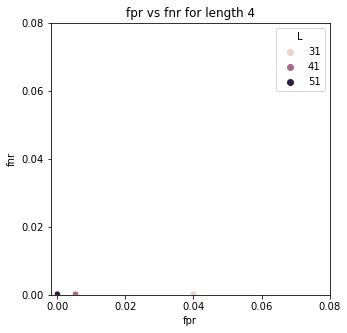

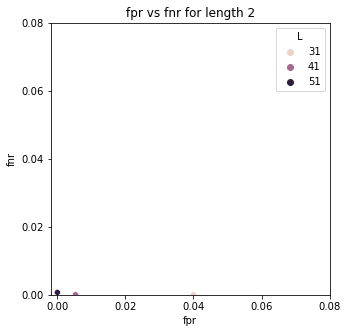

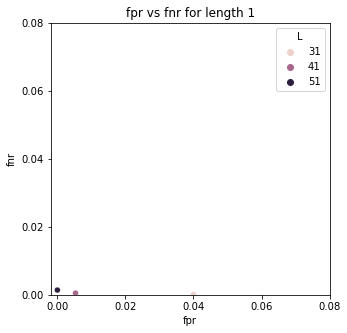

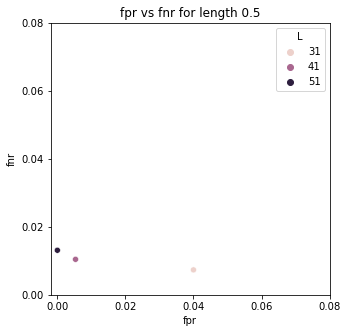

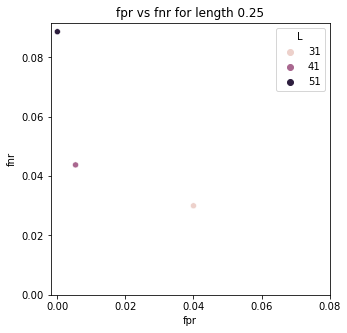

In [114]:
for leng in [4, 2, 1, 0.5, 0.25]:
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=rates[(rates['len']==leng) & (rates['L']<61)], x='fpr', y='fnr', hue='L', legend='full')
    plt.title(f'fpr vs fnr for length {leng}')
    plt.xticks(np.arange(0,0.1, 0.02))
    plt.yticks(np.arange(0, 0.1, 0.02))
    plt.show()

### Visualization

In [26]:
def plot_from_path(query_wav_path, ref_wav_path, size=15, top_bits=1, maj=1, multiplier=2, L=61):
    # get wav files
    srate, ref_wav = wavfile.read(ref_wav_path)
    srate, query_wav = wavfile.read(query_wav_path)
    # get hashprint and delta
    mask = get_filter(ref_wav_path, cfgObj)
    ref_hps, ref_deltas = get_hps_and_deltas(ref_wav_path, cfgObj, maskMatrix=mask)
    query_hps, query_deltas = get_hps_and_deltas(query_wav_path, cfgObj, maskMatrix=mask)
    # get offset
    offset = find_offset(query_hps, ref_hps)
    ref_deltas = get_ref_chunk(ref_deltas, offset, query_hps)
    query_deltas, ref_deltas = query_deltas[:top_bits].real, ref_deltas[:top_bits].real
    plt.scatter(query_deltas, ref_deltas, s=5)
    plt.show()
    plt.hist(query_deltas.reshape(-1)-ref_deltas.reshape(-1), bins=30)
    plt.show()
    # pearson r
    corr = st.pearsonr(query_deltas.reshape(-1), ref_deltas.reshape(-1))[0]
    # get outliers
    outliers = iqr_outliers(query_deltas, ref_deltas, multiplier=multiplier)
#     outliers = threshold_outliers(query_deltas, ref_deltas)
    votes = majority_vote(outliers, majority=maj)
    filtered = medfilt(votes, L)
    ### plot
    fs = int(cfgObj.get('sampling_freq')) # in Hz
    hop_size = float(cfgObj.get('hop_size')) # in sec
    fft_size = int(cfgObj.get('fft_size'))
    win_length = float(cfgObj.get('win_size')) # in sec
    win_samples = int(round(win_length*fs))
    noverlap_samples = win_samples - int(round(hop_size*fs))
    # reference spectrogram 
    plt.figure(figsize=(15, 3))
    plt.specgram(ref_wav[offset * srate // 100:offset * srate // 100 + srate * 10], NFFT=win_samples,Fs=fs,noverlap=noverlap_samples,pad_to=fft_size)
    plt.yticks([])
    plt.show()
    # query spectrogram 
    plt.figure(figsize=(size, 3))
    plt.specgram(query_wav, NFFT=win_samples,Fs=fs,noverlap=noverlap_samples,pad_to=fft_size)
    plt.yticks([])
    plt.show()
    # pearson r
    print(f'    Pearson r: {corr}')
    # hashprints
#     plt.figure(figsize=(size, 3))
#     diffs = [list(map(int, bin(query_hps[i] ^ ref_hps[offset+i])[2:].zfill(32))) for i in range(len(query_hps))]
#     diffs = np.array(diffs).T
#     plt.matshow(diffs[:top_bits], cmap='Greys', fignum=1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('hashprint diffs')
#     plt.show()
    # outliers
    plt.figure(figsize=(size, 3))
    plt.matshow(np.tile(outliers, [8, 1]), cmap='Greys', fignum=1)
    plt.xticks([])
    plt.yticks([])
    plt.title('outliers')
    plt.show()
    print('    Total outliers:', outliers.sum())
#     print(outliers.sum())
    # votes
#     plt.figure(figsize=(size, 3))
#     plt.matshow(np.tile(votes, [8, 1]), cmap='Greys', fignum=1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('votes')
#     plt.show()
#     print('    Total votes:', votes.sum())
    
    # votes
    plt.figure(figsize=(size, 3))
    plt.matshow(np.tile(filtered, [8, 1]), cmap='Greys', fignum=1)
    plt.xticks([])
    plt.yticks([])
    plt.title('filtered')
    plt.show()
    print('    Total filtered:', filtered.sum())

queries/query_2_m4_script3_clean-128k


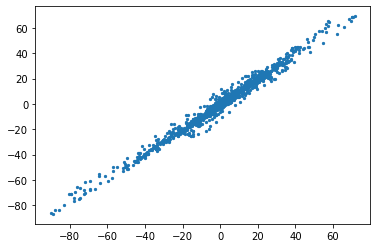

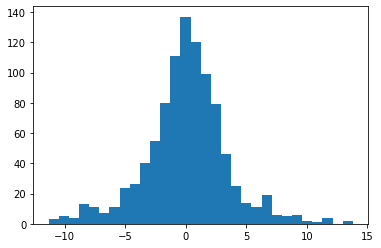

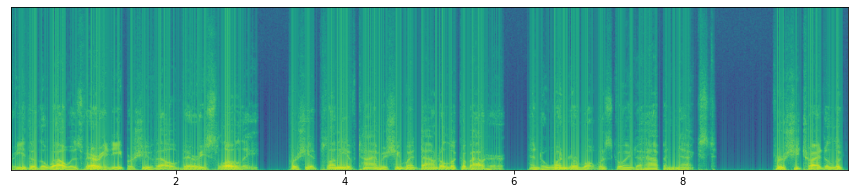

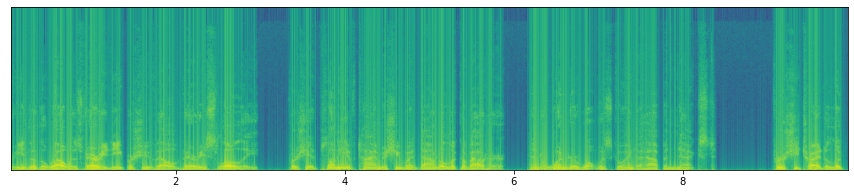

    Pearson r: 0.9910040446136013


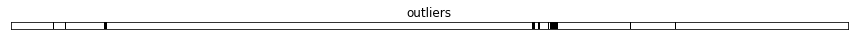

    Total outliers: 29


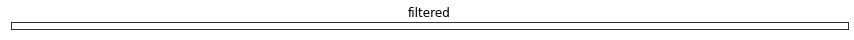

    Total filtered: 0


In [28]:
query = 'queries/query_2_m4_script3_clean-128k'
ref_name = '_'.join(query.split('_')[2:5]).split('-')[0]
ref_wav_path = f'./daps-mp3/clean/{ref_name}.wav'
query_wav_path = f'./daps-mp3/{query}.wav'
print(query)
plot_from_path(query_wav_path, ref_wav_path, 15*1)

queries/query_7_f5_script5_clean-64k


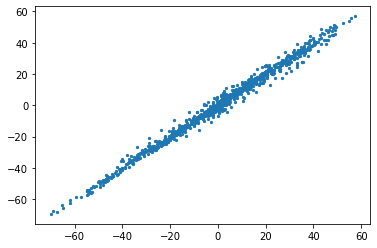

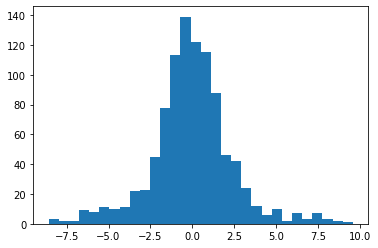

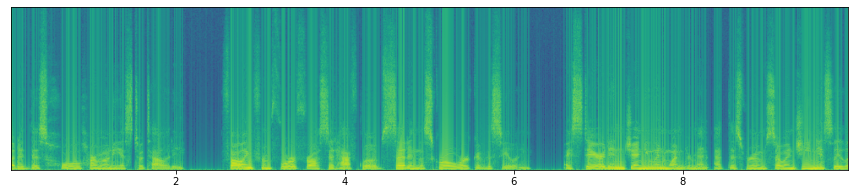

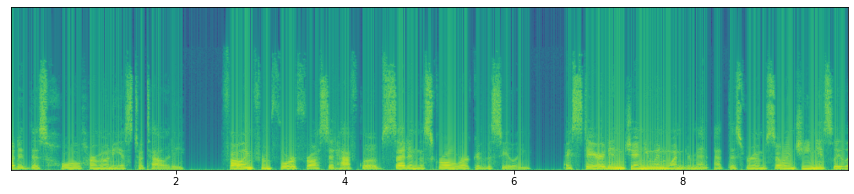

    Pearson r: 0.9950142450654356


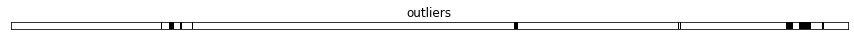

    Total outliers: 40


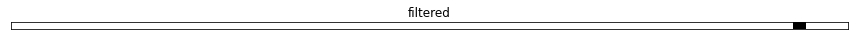

    Total filtered: 16


In [33]:
query = 'queries/query_7_f5_script5_clean-64k'
ref_name = '_'.join(query.split('_')[2:5]).split('-')[0]
ref_wav_path = f'./daps-mp3/clean/{ref_name}.wav'
query_wav_path = f'./daps-mp3/{query}.wav'
print(query)
plot_from_path(query_wav_path, ref_wav_path, 15*1, L=41)

tampered0.25/rep_8_f2_script1_clean-256k


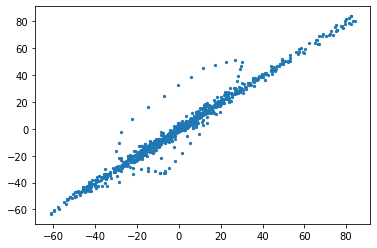

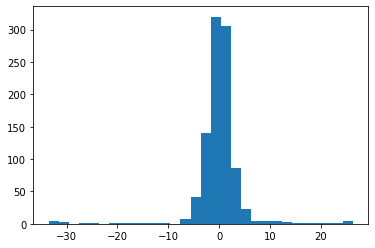

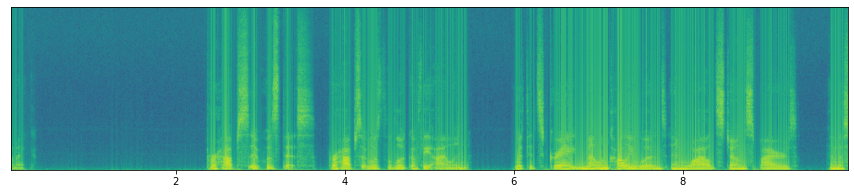

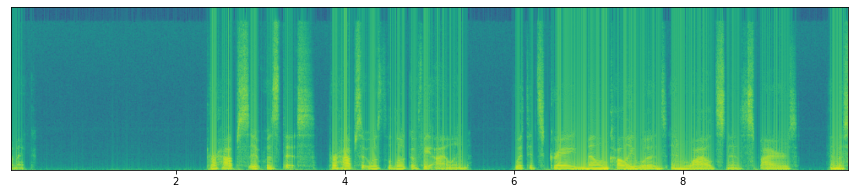

    Pearson r: 0.9837988657747083


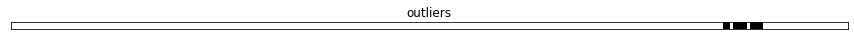

    Total outliers: 40


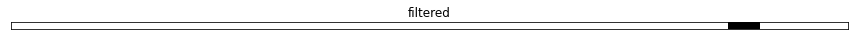

    Total filtered: 37


In [32]:
query = tamp_025[np.random.randint(3000, 4500)]
ref_name = '_'.join(query.split('_')[2:5]).split('-')[0]
ref_wav_path = f'./daps-mp3/clean/{ref_name}.wav'
query_wav_path = f'./daps-mp3/{query}.wav'
print(query)
plot_from_path(query_wav_path, ref_wav_path)

queries/query_8_f2_script1_clean-256k


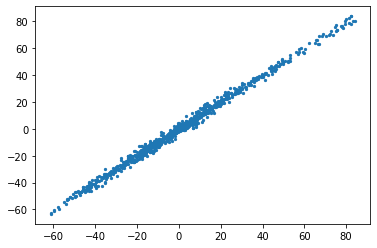

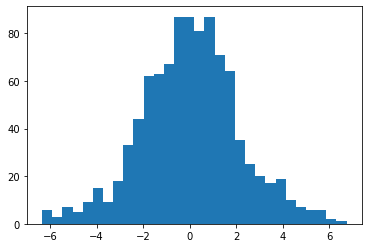

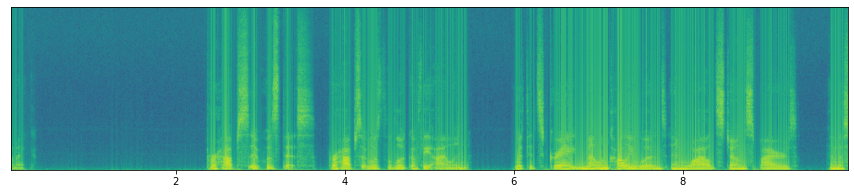

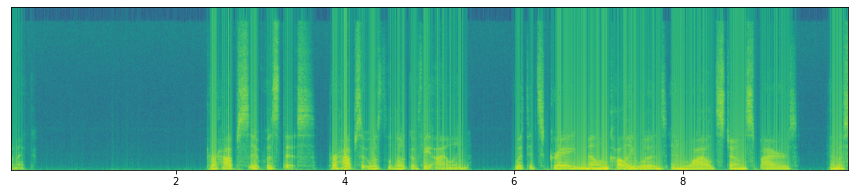

    Pearson r: 0.9968332174058638


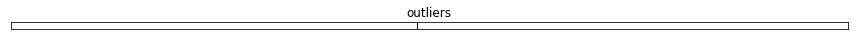

    Total outliers: 1


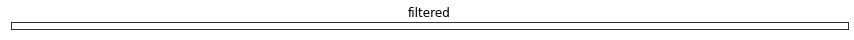

    Total filtered: 0


In [27]:
query = queries[np.random.randint(0, len(queries))]
# query = 'queries/query_7_m3_script2_clean-128k'
print(query)
ref_name = '_'.join(query.split('_')[2:5]).split('-')[0]
ref_wav_path = f'./daps-mp3/clean/{ref_name}.wav'
query_wav_path = f'./daps-mp3/{query}.wav'""
plot_from_path(query_wav_path, ref_wav_path, L=51)